In [1]:
import sys
sys.path.append("/home/anonymous/ECAP/nyx/")

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u

# Testing global configuration:

In [3]:
from nyx.core import config_summary, set_healpix_nside, config_context, get_wavelengths, get_healpix_nside, get_grid_dim

In [4]:
set_healpix_nside(2**4)
config_summary()

NYX Global Configuration
wavelengths                   : array(shape=(50,), dtype=float32)
                                (Wavelength grid in nm)
healpix_nside                 : 16
                                (HEALPix nside parameter)
use_hemisphere                : True
                                (Whether to use only upper hemisphere)
airmass_formula               : kasten_young_1989
                                (Airmass calculation formula)
grid_dim                      : 2
                                (Image interpolation grid dimension)
use_jit                       : True
                                (Whether to use JAX JIT compilation)
precision                     : float32
                                (Numerical precision for calculations)
spectral_method               : conserve
                                (Spectral interpolation method)
                                (Warn when spectral resolution is degraded)
gradient_checkpointing        : False
 

# Testing spectral interpolation:

In [5]:
from nyx.core import SpectralHandler

In [6]:
from nyx import ASSETS_PATH
ag_array = np.genfromtxt(ASSETS_PATH+'eso_skycalc_airglow_130sfu.dat')
wl_high = jnp.array(ag_array[:,0].flatten())
flux_high = jnp.array(ag_array[:,1].flatten())

In [7]:
results = {}
methods = ['linear', 'conserve']
for method in methods:
    with config_context(spectral_method=method, spectral_resolution_warning=False, wavelengths=jnp.linspace(320,700,30)):
        wl_low = get_wavelengths()
        flux_low = SpectralHandler.resample(wl_high, flux_high, wl_low)
        results[method] = flux_low
        
        # Calculate total flux
        mask = (wl_high>=jnp.min(wl_low))&(wl_high<=jnp.max(wl_low))
        total_in = jnp.trapezoid(flux_high[mask], wl_high[mask])
        total_out = jnp.trapezoid(flux_low, wl_low)
        conservation = total_out / total_in
        
        print(f"\n  {method.upper()} method:")
        print(f"    Flux conservation: {conservation:.1%}")
        print(f"    Peak preservation: {flux_low.max() / flux_high.max():.1%}")



  LINEAR method:
    Flux conservation: 82.7%
    Peak preservation: 0.0%

  CONSERVE method:
    Flux conservation: 99.7%
    Peak preservation: 0.0%


# Testing observation implementation:

In [8]:
import astropy
from astropy.coordinates import SkyCoord
from nyx.core import Observation

In [9]:
rotation = -0.25*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-06-18T22:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('sgr A*')
obs = Observation(location, obstime, target, rotation, fov=3*u.deg)

In [10]:
with config_context(grid_dim=4):
    print(obs.get_eval_coordinates(altaz=True))

<SkyCoord (AltAz: obstime=2021-06-18T22:14:16.000, location=(5622.333422015386, 1665.7099041749266, -2505.2121403078927) km, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [[(113.55574349, 76.51058982), (122.12088007, 76.81465948),
      (130.88712956, 76.82138984), (139.46912424, 76.53033512)],
     [(111.31645637, 78.45115886), (121.31029418, 78.80737191),
      (131.62919627, 78.81529136), (141.65006511, 78.47419918)],
     [(108.19391372, 80.36776942), (120.15417261, 80.7969695 ),
      (132.68815049, 80.80658281), (144.69548282, 80.39534926)],
     [(103.55971833, 82.24264048), (118.36819525, 82.78087615),
      (134.32561462, 82.7931001 ), (149.22605004, 82.27681408)]]>


# Testing atmosphere implementation:

In [11]:
from nyx.atmosphere import atmospheres

In [12]:
atmo = atmospheres.SingleScatteringAtmosphere(
        tau_rayleigh_func=lambda lam, h: 0.00878*(lam/1000)**-4.09 * jnp.exp(-h/8),
        tau_mie_func=lambda lam, h, aod, ang: aod*(lam/500)**(-ang) * jnp.exp(-h/1.54),
        hg_asymmetry=0.75
        )

In [13]:
%%time
atmo_gen, atmo_par = atmo.get_generator(obs)

CPU times: user 37.7 ms, sys: 6 μs, total: 37.7 ms
Wall time: 36.7 ms


In [14]:
%%time
params = {k:atmo_par[k].initial_value*0.95 for k in atmo_par}
res = atmo_gen(params)

CPU times: user 392 ms, sys: 20.3 ms, total: 412 ms
Wall time: 381 ms


# Testing instrument implementation:

In [15]:
from nyx.instrument import instruments

In [16]:
from nsb2.instrument import HESS
hess1 = HESS.CT1()
grid = np.stack([np.vstack(pix.centers) for pix in hess1.pixels])
values = np.stack([pix.values for pix in hess1.pixels])

HESS1 = instruments.EffectiveApertureInstrument(hess1.bandpass, grid, values)

In [17]:
%%time
inst_gen, inst_par = HESS1.get_generator(obs)

CPU times: user 64.5 ms, sys: 7.08 ms, total: 71.5 ms
Wall time: 67.7 ms


In [18]:
%%time
params = {k:inst_par[k].initial_value for k in inst_par}
res = inst_gen(params)

CPU times: user 81 ms, sys: 1.93 ms, total: 82.9 ms
Wall time: 79.6 ms


# Testing zodiacal light implementation:

In [19]:
from nyx.emitter import zodiacal
leinert = zodiacal.Leinert1998()

In [20]:
%%time
zod_gen, zod_par, zod_type = leinert.get_generator(obs)

CPU times: user 29.2 ms, sys: 0 ns, total: 29.2 ms
Wall time: 28.2 ms


In [21]:
%%time
params = {k:zod_par[k].initial_value for k in zod_par}
res = zod_gen(params)

CPU times: user 446 μs, sys: 0 ns, total: 446 μs
Wall time: 291 μs


# Testing airglow implementation:

In [22]:
from nyx.emitter import airglow
glow = airglow.ESOSkyCalc()

In [23]:
%%time
glow_gen, glow_par, glow_type = glow.get_generator(obs)

/home/anonymous/ECAP/nyx/nyx/core/spectral.py:49: UserWarning: Spectral resolution degraded from 0.5 to 8.2 nm. Consider using 'conserve' method to preserve features.
  warnings.warn(


CPU times: user 457 ms, sys: 16 ms, total: 473 ms
Wall time: 398 ms


In [24]:
%%time
params = {k:glow_par[k].initial_value for k in glow_par}
res = glow_gen(params)

CPU times: user 137 ms, sys: 10 ms, total: 147 ms
Wall time: 144 ms


# Testing moonlight implementation:

In [25]:
from nyx.emitter import moon
jones = moon.Jones2013()

In [26]:
%%time
moon_gen, moon_par, moon_type = jones.get_generator(obs)

CPU times: user 47.9 ms, sys: 4.71 ms, total: 52.6 ms
Wall time: 50.9 ms


In [27]:
%%time
params = {k:moon_par[k].initial_value for k in moon_par}
res = moon_gen(params)

CPU times: user 0 ns, sys: 1.2 ms, total: 1.2 ms
Wall time: 622 μs


# Testing catalog implementation:

# Testing model implementation:

In [50]:
from nyx.core.model import Model

In [51]:
pipeline = Model(HESS1, atmo, [glow, leinert, jones])
scene = pipeline.query(obs)

In [52]:
initial_params = scene.get_initial_parameters()

In [53]:
print("\nInitial Parameters:")
scene.print_parameters(format='table')


Initial Parameters:
┌──────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Component  │ Type       │ Parameter     │ Shape  │ Initial  │ Current │ Bounds │ Description             │ 
├──────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ atmosphere │ atmosphere │ obs_height_km │ (1,)   │ 0.0000   │ -       │ -      │ Observatory height [km] │ 
│ atmosphere │ atmosphere │ aod_500       │ (1,)   │ 0.1000   │ -       │ -      │ AOD at 500nm            │ 
│ atmosphere │ atmosphere │ angstrom_exp  │ (1,)   │ 1.0000   │ -       │ -      │ Angstrom exponent       │ 
│ atmosphere │ atmosphere │ hg_asymmetry  │ (1,)   │ 0.7500   │ -       │ (0, 1) │ HG asymmetry            │ 
│ instrument │ instrument │ shift         │ (2,)   │ -        │ -       │ -      │ Pixel shift in rad      │ 
│ instrument │ instrument │ flatfield     │ (960,) │ -        │ -       │ -      │ Flatfielding value

# Testing scene rendering:

In [54]:
from nyx.core.integrator import render

In [55]:
scene_instance = scene.realize(initial_params)
img = render(scene_instance)

# Visualize data

In [68]:
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
cam = CameraGeometry.from_name('HESS-I')
def ctapipe_disp(cam, rates, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = rates
    display.add_colorbar(label=label)
    return display

/usr/local/lib/python3.13/site-packages/ctapipe/instrument/camera/geometry.py:616: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


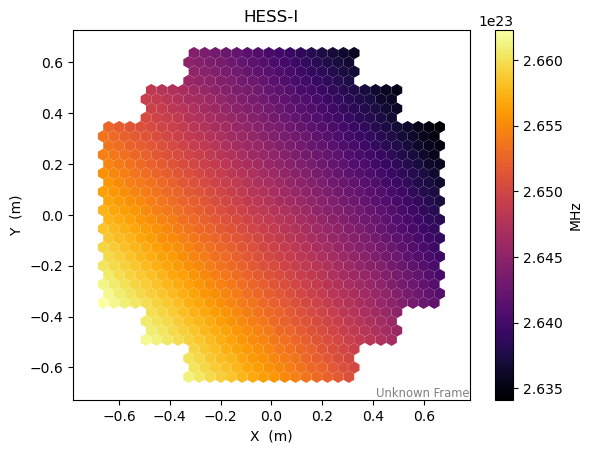

In [69]:
fig, ax = plt.subplots()
disp = ctapipe_disp(cam, img, ax, label='MHz')